# Imports

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

In [4]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image data
])

# Load the dataset, it is already split into test and training
train_dataset = ImageFolder('archive/train/', transform=transform)
test_dataset = ImageFolder('archive/test/', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Models

In [6]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


In [7]:

models = {"model1":
          {
            "model": Model1,
            "epochs": 10,
            "learning_rate": 0.001,
            "loss_function": nn.CrossEntropyLoss,
            "optimiser": optim.Adam
          }
}

# Training the models

In [8]:

for model_name in models:

    model = models[model_name]["model"]
    learning_rate = models[model_name]["learning_rate"]
    epochs = models[model_name]["epochs"]
    loss_function = models[model_name]["loss_function"]()
    optimiser = models[model_name]["optimiser"]

    print(f"Training {model_name}...")

    model = model()
    
    optimiser = optimiser(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):

        model.train()
        running_loss = 0.0

        for images, labels in train_loader:

            optimiser.zero_grad()

            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
        print("\n")

    # Save the trained model
    torch.save(model.state_dict(), f"model_saves/{model_name}.pth")


Training model1...
Epoch [1/10], Loss: 1.5601769863629926


Epoch [2/10], Loss: 1.3366952675886303


Epoch [3/10], Loss: 1.2040378433426133


Epoch [4/10], Loss: 1.0740277775810132


Epoch [5/10], Loss: 0.9366900593639748


Epoch [6/10], Loss: 0.7957581805691687


Epoch [7/10], Loss: 0.6552607199397013


Epoch [8/10], Loss: 0.529562474790554


Epoch [9/10], Loss: 0.4118900903083699


Epoch [10/10], Loss: 0.31961917257421796




# Computing the metrics

In [9]:
def calculate_metrics(y_true, y_pred):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average='weighted')
    recall = metrics.recall_score(y_true, y_pred, average='weighted')
    f1_score = metrics.f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1_score

# Assessing the models

In [10]:
for model_name in models:
    
    print(f"Evaluating {model_name}")

    model = models[model_name]["model"]
    model = model()

    # Load the trained model state dictionary
    model.load_state_dict(torch.load(f"model_saves/{model_name}.pth"))

    # Evaluation mode
    model.eval()

    # Lists to store predictions and ground truth labels
    all_predictions = []
    all_labels = []

    # Iterate over the test dataset
    for images, labels in test_loader:

        # Forward pass: compute predicted outputs
        outputs = model(images)

        # Get the predicted labels
        _, predictions = torch.max(outputs, 1)

        # Convert predictions and labels to CPU tensors
        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()

        # Store predictions and labels
        all_predictions.extend(predictions)
        all_labels.extend(labels)

    # Compute metrics
    accuracy, precision, recall, f1_score = calculate_metrics(all_labels, all_predictions)

    # Print the metrics
    print(f"Model Name: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}\n")

Evaluating model1
Model Name: model1
Accuracy: 0.5186681526887712
Precision: 0.5256003222472391
Recall: 0.5186681526887712
F1 Score: 0.5189659870676103



# Visualising layers

In [11]:
def visualize_feature_maps(model, image):
    
    activations = []
    layer_names = []

    for name, module in model.named_modules():
        layer_names.append(name)
        activations.append(module(image))

    fig, axs = plt.subplots(1, len(activations))
    for i, activation in enumerate(activations):
        axs[i].imshow(activation[0][0].detach().numpy(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(layer_names[i])

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

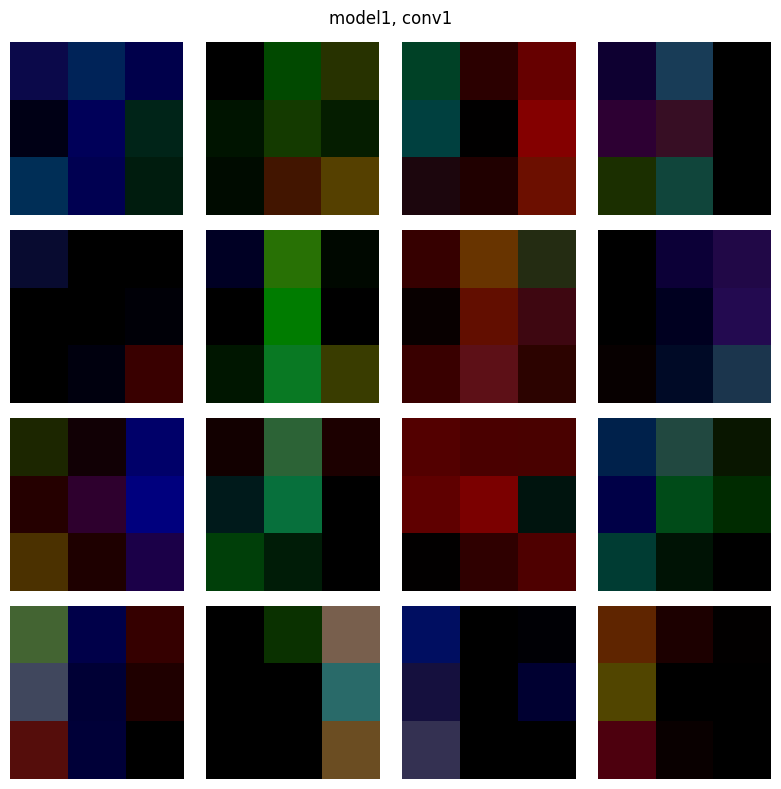

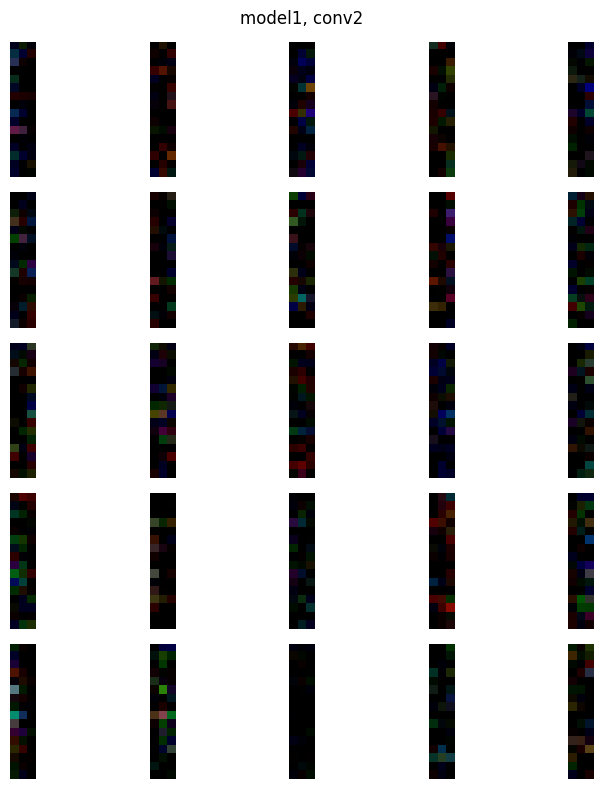

In [53]:
for model_name in models:

    model = models[model_name]["model"]()
    model.load_state_dict(torch.load(f'model_saves/{model_name}.pth'))
    model.eval()

    # Iterate over the model's modules
    for name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):
            # Get the filter weights for the convolutional layer
            filter_weights = module.weight.data

            # Visualize the filter weights as images
            num_filters = filter_weights.size(0)
            grid_size = int(num_filters ** 0.5)  # Calculate grid size for subplots

            # Create a subplot for each filter
            fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

            # Plot each filter weight
            for i, ax in enumerate(axes.flat):
                filter_weight = filter_weights[i]
                filter_weight = filter_weight.cpu().numpy()
                ax.imshow(filter_weight, cmap='gray')
                ax.axis('off')

            # Display the figure with the name of the convolutional layer
            plt.suptitle(f"{model_name}, {name}")
            plt.tight_layout()
            plt.savefig(f"layer_visualisations/{model_name}_{name}.png")